<a href="https://colab.research.google.com/github/gitgubbenito/AI_ML/blob/main/Car_Insurance_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vehicle-claim-fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1807255%2F2947792%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T172803Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8217a4f7eae7770c29bdaf092e3f1d7e893fa63ef79ada821fcc57e483b863b91b600c9ba0c727e606599c4fdd513aac48e9889c43cb6eb6968994702d9d86af2be6debcda9c9459c1bfa874f35f5e95d43f36d0390ac21fa44305ac33b9f0c4c523e27fc1f03b14924729ab2da40cda2a15f6e59580967feb646e4ffd0e60b0ce7025e7a112d05c1e5637cb8f895dd951a88d733df9ff04f3dc36b0eca43451b532b6bdc7b77c47b321fcaeda627d1f70ef0347be2447372d89e56a6158cf21d1dae7c5ca1e1b421699e5d18f33e8c3f59e4660818476e528b9020e1326ff6c2bbaacda8f3f2c4a0818abcb566d532e6240cb718296d1e1ec67f5660fb2ab31'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 356667 bytes downloaded
Downloaded and uncompressed: vehicle-claim-fraud-detection
Data source import complete.


<H1 style="text-align:center; font-size : 40px; font-family : 'Poppins'; "><strong>Data Science Final Project - Car Insurance Fraud Detection</strong>  </H1>

<a id = '0'></a>
<p style = "font-size : 35px; font-family : 'Poppins'; border-radius: 10px; "><strong>Table of Content</strong></p>

* [Data Analysis](#1.0)
    * [Data Exploration](#1.1)
    * [Data Visualization](#1.2)
    * [Handling Missing Values](#1.3)
    * [Normalization](#1.4)
    * [Creating New Features](#1.5)
    * [Label Encoding](#1.6)
    * [Handling Imbalanced Data](#1.7)
    * [Features Selection](#1.8)
    
* [Models](#2.0)
    * [Support Vector Classifier](#2.1)
    * [Knn](#2.2)
    * [Decision Tree Classifier](#2.3)
    * [Random Forest Classifier](#2.4)
    * [Ada Boost Classifier](#2.5)
    * [Gradient Boosting Classifier](#2.6)
    * [Stochastic Gradient Boosting (SGB)](#2.7)
    * [XgBoost](#2.8)
    * [Cat Boost Classifier](#2.9)
    * [Extra Trees Classifier](#2.10)
    * [LGBM Classifier](#2.11)
    * [Voting Classifier](#2.12)

* [Models Comparison](#3.0)

### Import Libraries

In [9]:
!pip install category_encoders
#!pip install category_encoders.ordinal

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import KFold
import time


from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate


import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [12]:
df = pd.read_csv('/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv')

<a id = '1.0'></a>
<p style = "font-size : 35px; font-family : 'Poppins'; border-radius: 10px;"><strong>Data Analysis</strong></p>

<a id = '1.1'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong>Data Exploration</strong></p>

In [14]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [16]:
# Get an overview of the dataset
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [18]:
# Summary statistics for numerical columns - will help us see relevant statistics
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [19]:
# Check for missing values
df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [20]:
#Checking for duplicate values
df.duplicated().sum()

0

<a id = '1.2'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong>Data Visualization</strong></p>

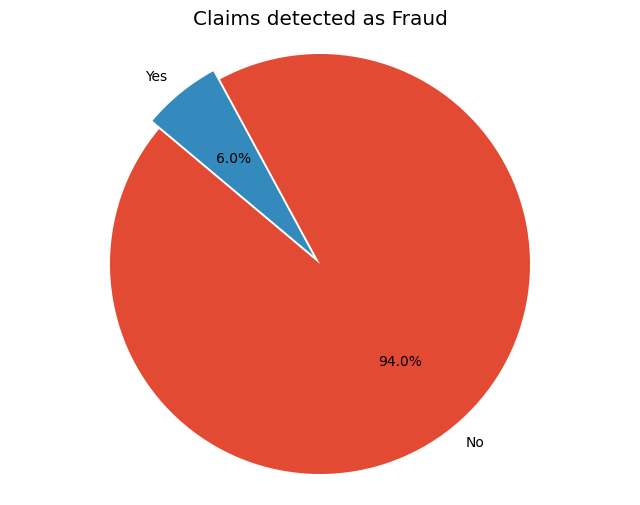

In [21]:
df = df.rename(columns={'FraudFound_P': 'FraudFound'})

# Check how many records are fraud and plot pie chart
labels = df.FraudFound.value_counts().index
labels = ["No" if i==0 else "Yes" for i in labels]
sizes = df.FraudFound.value_counts().values


plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,explode=[0.05,0])
plt.title('Claims detected as Fraud')
plt.axis('equal')
plt.show()

***Only 6% of the claims reported as fraud. As it was expected, the dataset is imbalanced***

### I'll Show how many claims in the data are actually fraud from each vehicle category (Seden, Sport, Utility):

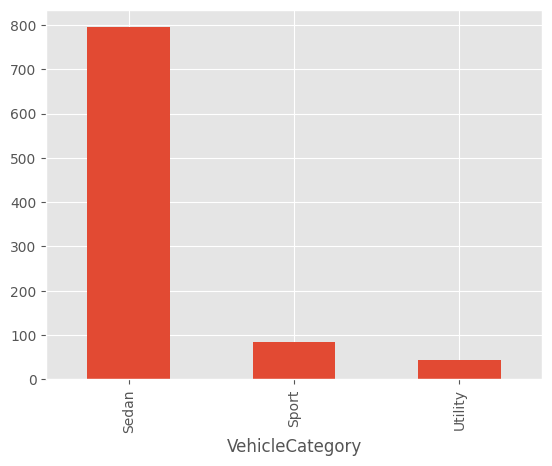

In [22]:
# Filter the data for all claims that are Fraud
df_fraud = df[df['FraudFound'] == 1]
# Count the number claims in each vehicle category
fraud_counts = df_fraud['VehicleCategory'].value_counts()
fraud_counts.plot(kind='bar')
plt.show()


***The majority of fraud claims are of sedan cars.***


In [ ]:
# Explore age distribution in general and in fraud records

plt.figure(figsize=(10, 5))
# Age histogram
plt.subplot(1, 2, 1)
plt.hist(df['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Histogram')


mapping_dict = {
    '16 to 17': '16-17',
    '18 to 20': '18-20',
    '21 to 25': '21-25',
    '26 to 30': '26-30',
    '31 to 35': '31-35',
    '36 to 40': '36-40',
    '41 to 50': '41-50',
    '51 to 65': '51-65',
    'over 65': '65+'
}

# Replace values in the DataFrame column
df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].replace(mapping_dict)

# Frauds Per Policy Holder Age Group histogram
plt.subplot(1, 2, 2)
policyAge = df.groupby('AgeOfPolicyHolder')['FraudFound'].sum()
bars = plt.bar(policyAge.index, policyAge.values, edgecolor='black')
plt.title("Frauds Per Policy Holder Age Group")
plt.xlabel("Policy Holder Age Group")
plt.ylabel("Number Of Fraud Claims")
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


***We can notice that there are few records (less than 500) that the age is less than 10, probably missing data got 0 value. We will rtake care of it later***


In [ ]:
#Frauds per Car Make
make_frauds = df.groupby('Make')['FraudFound'].sum()
make_frauds = make_frauds.sort_values(ascending=False)

norm = plt.Normalize(make_frauds.min(), make_frauds.max())
colors = plt.cm.coolwarm(norm(make_frauds.values))

plt.figure(figsize=(20, 8))
bars = plt.bar(make_frauds.index, make_frauds.values, color=colors)
plt.title("Frauds per Car Make")
plt.xlabel("Car Make")
plt.ylabel("Fraud Claims")


sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#Car make count
make_car = df['Make'].value_counts()
plt.figure(figsize=(20, 8))
bars = plt.bar(make_car.index, make_car.values, color=colors)
plt.title("Car make count")
plt.xlabel("Car Make")
plt.ylabel("Fraud Claims")


sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* ***On the first graph We can see that for luxury cars like Jaguar Ferrari and Porche there are few to zero evidence of frauds, while the majority of fraudclaims are for car makes like Toyota, Honda and pontiac.***
* ***On the second graph we can see that the total numbers of claims for the luxury cars is low from beginning.***


In [ ]:
# Pie Chart to see Fraud records by sex(male/female)
fraud_by_sex = df[df['FraudFound'] == 1].groupby('Sex').size()
fig, ax = plt.subplots()
ax.pie(fraud_by_sex, labels=fraud_by_sex.index, autopct='%1.1f%%', startangle=180, explode=[0.05,0])
ax.axis('equal')
ax.set_title('Fraud Cases by Sex')

plt.show()

In [ ]:
# Plot of Accident Area by sex for fraud cases
sns.countplot(data=df[df['FraudFound'] == 1], x='AccidentArea', hue='Sex')
plt.title('Region Distribution by Sex')
plt.xlabel('AccidentArea')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.show()


In [ ]:
# Plot Fraud cases by fault - policy holder/third party
fraud_by_fault_fraud = df[df['FraudFound'] == 1].groupby('Fault').size()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1 - Fraud Cases by Fault
axs[0].pie(fraud_by_fault_fraud, labels=fraud_by_fault_fraud.index, autopct='%1.1f%%', explode=[0.05,0])
axs[0].axis('equal')
axs[0].set_title('Fraud Cases by Fault')

# Plot All cases by fault - policy holder/third party
fraud_by_fault_all = df.groupby('Fault').size()


fraud_by_fault_all = fraud_by_fault_all.reindex(fraud_by_fault_fraud.index, fill_value=0)

# Plot 2 - All Cases by Fault
axs[1].pie(fraud_by_fault_all, labels=fraud_by_fault_all.index, autopct='%1.1f%%',explode=[0.05,0])
axs[1].axis('equal')
axs[1].set_title('All Cases by Fault')

plt.tight_layout()
plt.show()

***We can see that most of fraud cases where claimed by the policy holder***

In [ ]:
fraud_by_cars = df[df['FraudFound'] == 1].groupby('NumberOfCars').size()
fig, ax = plt.subplots()
ax.bar(fraud_by_cars.index.astype(str), fraud_by_cars)
ax.set_xlabel('Number of Cars')
ax.set_ylabel('Number of Fraud Cases')
ax.set_title('Fraud Cases by number of cars')

plt.show()

<a id = '1.3'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong>Handling Missing Values</strong></p>


**First we will see all unique values**

In [ ]:
# get rid of policy number column
df.drop(columns=['PolicyNumber'], inplace=True)

In [ ]:
def get_unique_values_df(df):
    """
    Generate a DataFrame displaying unique values for each column in the input DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame containing data.

    Returns:
    DataFrame: DataFrame with columns 'Column Name' and 'Unique Values'.
    """
    pd.set_option('max_colwidth', None)
    data = []
    for column in df:
        unique_values = ', '.join(map(str, df[column].unique()))
        data.append([column, unique_values])

    # Create a new DataFrame to display the unique values
    unique_values_df = pd.DataFrame(data, columns=['Column Name', 'Unique Values'])
    return unique_values_df







get_unique_values_df(df)

**We can notice:**
* DayOfWeekClaimed - contains a 0 instead of a day of the week
* MonthClaimed - contains a 0 instead of the month
* Age - contains a 0 instead of the age
* PolicyType - appears to be a concatenation of VehicleCategory and BasePolicy

In [ ]:
#Investigate the 0 in DayOfWeekClaimed and MonthClaimed
print('DayOfWeekClaimed has ', len(df.loc[(df['DayOfWeekClaimed']=='0')]), ' row(s) with a 0')
print('MonthClaimed has ',len(df.loc[(df['MonthClaimed']=='0')]),' row(s) with a 0\n')


# Idendtify which row effected
print('Row ', df.loc[(df['DayOfWeekClaimed']=='0')].index[0], ' has 0 value in DayOfWeekClaimed')
print('Row ', df.loc[(df['MonthClaimed']=='0')].index[0], ' has 0 value in MonthClaimed')

# Both are zero in the same row (row 1516).

# we will drop this row
df = df.loc[df['DayOfWeekClaimed']!='0']


**Now we have to take care of the 0 value on the Age category**

In [ ]:
# There are 319 records where the age is 0. out of them 30 records are frauds, I will replace the 0 with the AgeOfPolicyHolder
print('There are ', len(df[df['Age']==0]), 'records where the age is 0')

# For all this rows policy holder age  is between 16 and 17 years old.
print('For all this rows policy holder age is: ', df.loc[(df['Age']==0),'AgeOfPolicyHolder'].unique())

In [ ]:
df[df['Age'] == 0][['Age', 'AgeOfPolicyHolder']]

<a id = '1.4'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong>Normalization</strong></p>


In [ ]:
# I Will replace all 0 values with 16 or 17 randomly
random_ages = np.random.choice([16, 17], size=df['Age'].eq(0).sum())
df.loc[df['Age'] == 0, 'Age'] = random_ages

print('Now there are ', len(df[df['Age']==0]), 'records where the age is 0')


**Iv'e noticed that the policy type is concatenation of the VehicleCategory and the BasePolicy, for now we will drop this column.**

In [ ]:
# df.drop(columns=['PolicyType'], inplace=True)

<a id = '1.5'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong>Creating New Features:</strong></p>


In [ ]:
#I will create bins for the age group: 'Young', 'Middle-Aged', 'Senior'
age_groups = {
    '16-17': 'Young',
    '18-20': 'Young',
    '21-25': 'Young',
    '26-30': 'Young',
    '31-35': 'Middle-aged',
    '36-40': 'Middle-aged',
    '41-50': 'Middle-aged',
    '51-65': 'Senior',
    '65+': 'Senior'
}
df['AgeGroup'] = df['AgeOfPolicyHolder'].map(age_groups)
df.drop(columns=['AgeOfPolicyHolder'], inplace=True)

# Function to categorize ranges
def categorize_range(value):
    if value == 'less than 20000':
        return 'low'
    elif value in ['20000 to 29000', '30000 to 39000']:
        return 'mid'
    elif value in ['40000 to 59000', '60000 to 69000', 'more than 69000']:
        return 'high'
    else:
        return 'mid'  # or handle as needed

# Apply categorization to DataFrame
df['VehiclePrice_Cat'] = df['VehiclePrice'].apply(categorize_range)


<a id = '1.6'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong> Label Encoding:</strong></p>


In [ ]:
# Initialize LabelEncoder for encoding categorical columns
label_encoder = LabelEncoder()

# Define mappings for ordinal encoding
col_ordering = [
    {'col':'PastNumberOfClaims','mapping':{'none':0 ,'1':1,'2 to 4':3,'more than 4':5 }},
    {'col':'NumberOfSuppliments','mapping':{'none':0,'1 to 2':1,'3 to 5':3,'more than 5':6}},
    {'col':'VehiclePrice','mapping':{'more than 69000':5,'20000 to 29000':1,'30000 to 39000':2,'less than 20000':0,
                                     '40000 to 59000':3,'60000 to 69000':4}},
    {'col':'AgeOfVehicle','mapping':{'new': 0, '2 years': 1, '3 years': 2, '4 years': 3, '5 years': 4, '6 years': 5, '7 years': 6, 'more than 7': 7}},
    {'col':'Year','mapping': {1994: 0, 1995: 1, 1996: 2}},
    {'col':'Days_Policy_Accident','mapping': {'none': 0, '1 to 7': 1,'8 to 15': 2,'15 to 30': 3, 'more than 30': 4}},
    {'col':'Days_Policy_Claim','mapping': {'none': 0, '1 to 7': 1,'8 to 15': 2,'15 to 30': 3, 'more than 30':4 }},
    {'col':'AddressChange_Claim','mapping': {'1 year': 1, 'no change': 0, '4 to 8 years': 4, '2 to 3 years': 2, 'under 6 months': 0.5}},
    {'col':'AgeGroup','mapping': {'Young': 0, 'Middle-aged': 1, 'Senior': 2}},
    {'col':'VehiclePrice_Cat','mapping': {'high': 2, 'mid': 1, 'low': 0}},
    {'col':'NumberOfCars','mapping': {'3 to 4': 3, '1 vehicle': 1, '2 vehicles': 2, '5 to 8': 7, 'more than 8': 9}},
]
ord_encoder = OrdinalEncoder(mapping = col_ordering, return_df=True)

df = ord_encoder.fit_transform(df)



# Encode remaining categorical columns using LabelEncoder
for col in df.columns:
    if df[col].dtype == 'object':  # Check if the column is categorical
        df[col] = label_encoder.fit_transform(df[col])


# see how the unique  data in the dataframe look like
get_unique_values_df(df)

<a id = '1.7'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong>Handling Imbalanced Data</strong></p>


**We have seen that the data is imbalanced as the total cases of fraud are around 6%. I will use resample technique to make the data balanced**

In [ ]:
# We can see that the data is imbalanced
print('Number of records not  commited fraud: ',len(df[df['FraudFound']==0]))
print('Number of records commited fraud: ',len(df[df['FraudFound']==1]))
print('The total number of records is: ', len(df))

Split the data into train, test:

In [ ]:
X = df.drop(columns = 'FraudFound', axis = 1)
y = df.FraudFound

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Apply SMOTE - Synthetic Minority Oversampling Technique:**

In [ ]:
#Apply SMOTE to the training data:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<a id = '1.8'></a>
<p style = "font-size : 25px; font-family : 'Poppins'; border-radius: 10px;"><strong>Features Selection</strong></p>
Here I want to see the basic correlation between all feature to the target feature

In [ ]:
# let's explore the simple piercon correlation of all features regarding the target value
corr_map = df.corr()['FraudFound'].abs().sort_values(ascending=False)
corr_map

In [ ]:
corr_matrix = df.corr()
correlation_threshold = 0.05
# Filter features based on correlation threshold
relevant_features = corr_map[corr_map >= correlation_threshold].index.tolist()

df_filtered = df[relevant_features]
corr_matrix_filtered = df_filtered.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

**here I create feature selection function with random forest classifier. We will use it later in the models avaluation.**

In [ ]:
def select_features_rf(X, y, num_features=12, n_estimators=100, random_state=42):
    """
    Perform feature selection using Random Forest classifier.

    Parameters:
    - X: DataFrame or array-like, features
    - y: Series or array-like, target variable
    - n_estimators: int, optional (default=100), number of trees in the forest
    - num_features: int number of relevant features -deafult 12

    Returns:
    - selected_features: List of selected relevant features
    """
    # Initialize Random Forest classifier
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_features='auto', random_state=random_state)


    rf_clf.fit(X, y)

    # Get feature importances
    feature_importances = rf_clf.feature_importances_

    # Create DataFrame of feature importances
    feat_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort features by importance
    feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

    # Select top features (adjust as needed)
    selected_features = feat_importance_df.loc[feat_importance_df['Importance'] > 0.01, 'Feature'].tolist()[:num_features]

    return selected_features


## Example of the features selected

In [ ]:
selected_features = select_features_rf(X_train_resampled, y_train_resampled)
selected_features

<a id = '2.0'></a>
<p style = "font-size : 35px; font-family : 'Poppins'; border-radius: 10px;"><strong>Models</strong></p>


## I decided to use 5 classification/regression models:
* Logistic Regression
* Random Forest Classifier
* Gaussian Naive Bayes
* Decision Tree Classifier
* Gradient Boosting Classifier

In [ ]:
models_to_test = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier': RandomForestClassifier,
    'GaussianNB': GaussianNB,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}

# **Here I define the main function. It will compare all the selected models. we can use cross validation, feature selection and hypermarams tuning:**

In [ ]:
def run_models_and_evaluate(X, y, models, hyperparameters=None, feature_set=None, use_cross_val=False):
    """
    Train and evaluate machine learning models using specified hyperparameters and feature sets.

    Parameters:
    - X: DataFrame or array-like, features
    - y: Series or array-like, target variable
    - models: dict, key-value pairs of model names and corresponding model classes
    - hyperparameters: dict, optional, key-value pairs of model names and hyperparameter dict
    - feature_set: tuple, optional, key-value pairs of feature set names and corresponding feature list
    - use_cross_val: bool, optional, whether to use 10-fold cross-validation for evaluation (default=False)

    Returns:
    - results: list of dictionaries containing model evaluation results
    """
    results = []

    # Check if hyperparameters and feature sets are provided
    if hyperparameters is None:
        hyperparameters = {model_name: {} for model_name in models}
        # Set random_state=42 for RandomForestClassifier and DecisionTreeClassifier
        for model_name in hyperparameters:
            if model_name in ['RandomForestClassifier', 'DecisionTreeClassifier']:
                hyperparameters[model_name]['random_state'] = 42
    if feature_set is None:
        feature_set = ('All Features', list(X.columns))
    feature_set_name, featureset = feature_set[0], feature_set[1]


    # Iterate over models, hyperparameters, and feature sets
    for model_name, model in models.items():
        # Get the hyperparameters dictionary
        params = hyperparameters.get(model_name, {})
        if use_cross_val:
            kf = KFold(n_splits=10, shuffle=True, random_state=42)
            accuracies = []
            precisions = []
            recalls = []
            times = []
            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                model_instance = model(**params)

                start_time = time.time()
                model_instance.fit(X_train[featureset], y_train)
                train_time = time.time() - start_time

                start_time = time.time()
                y_pred = model_instance.predict(X_test[featureset])
                test_time = time.time() - start_time

                accuracies.append(accuracy_score(y_test, y_pred))
                precisions.append(precision_score(y_test, y_pred))
                recalls.append(recall_score(y_test, y_pred))

                times.append((train_time, test_time))

            avg_accuracy = sum(accuracies) / len(accuracies)
            avg_precisions = sum(precisions) / len(precisions)
            avg_recalls = sum(recalls) / len(recalls)
            avg_train_time = sum([t[0] for t in times]) / len(times)
            avg_test_time = sum([t[1] for t in times]) / len(times)
            results.append({
                'Model': model_name,
                'Hyperparameters': params,
                'Featureset': feature_set_name,
                'Accuracy': avg_accuracy,
                'Precision': avg_precisions,
                'Recall': avg_recalls,
                'Avg Train Time': avg_train_time,
                'Avg Test Time': avg_test_time
            })
        else:
            model_instance = model(**params)

            start_time = time.time()
            model_instance.fit(X[featureset], y)
            train_time = time.time() - start_time

            start_time = time.time()
            y_pred = model_instance.predict(X[featureset])
            test_time = time.time() - start_time

            accuracy = accuracy_score(y, y_pred)
            precision = precision_score(y, y_pred)
            recall = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)

            results.append({
                'Model': model_name,
                'Hyperparameters': params,
                'Featureset': feature_set_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'f1 score': f1,
                'Train Time': train_time,
                'Test Time': test_time
            })

    return results




# This is function to print all result in table - for ease:

In [ ]:
def print_dict_as_table(model_results):
    headers = model_results[0].keys()  # Get headers from the first dictionary in the list
    table_data = [[result[header] for header in headers] for result in model_results]

    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt='grid'))



### First, I will test all models on the dataset, without features selection and without cross validation and see the results

In [ ]:
# Define the hyperparams dict for each model, i encountered weired results without setting those params for those models
hyperparameters_to_test = {
    'RandomForestClassifier': {'max_depth': 5},
    'DecisionTreeClassifier': {'max_depth': 5},
}


# Get all results
models_results_ = run_models_and_evaluate(X_train_resampled, y_train_resampled, models=models_to_test,
                                                 hyperparameters=hyperparameters_to_test,
                                                 use_cross_val=False)

print_dict_as_table(models_results)

*  **We can see that GradientBoostingClassifier gave the best scores results but took the highest time to train**
* **We can see that GaussianNB gave the worst scores results but took very low time to train**


## Ok now we will give each model 2 params with starting values and use 10 fold cross validation

In [ ]:
hyperparameters_to_test = {
    'LogisticRegression': {'solver': 'liblinear', 'C': 0.1, 'random_state': 42},
    'RandomForestClassifier': {'n_estimators': 100, 'max_depth': 5, 'random_state': 42},
    'GaussianNB': {'priors': [0.1, 0.9]},
    'DecisionTreeClassifier': {'max_depth': 5, 'random_state': 42},
    'GradientBoostingClassifier': {'n_estimators': 100, 'learning_rate': 0.1, 'random_state': 42}
}


models_results_initial_hyper_params = run_models_and_evaluate(X_train_resampled, y_train_resampled, models=models_to_test,
                                                 hyperparameters=hyperparameters_to_test,
                                                 use_cross_val=True)

print_dict_as_table(models_results_initial_hyper_params)

## I will use features selection to choose the 12 most significant features using the function - select_features_rf

In [ ]:
selected_features = select_features_rf(X_train_resampled, y_train_resampled, num_features=12)
selected_features

In [ ]:
models_results_initial_hyper_params_selected_features = run_models_and_evaluate(X_train_resampled, y_train_resampled, models=models_to_test,
                                                 hyperparameters=hyperparameters_to_test,
                                                 feature_set=('Selected Features', selected_features),
                                                 use_cross_val=True)

print_dict_as_table(models_results_initial_hyper_params_selected_features)

In [ ]:
selected_features = select_features_rf(X_train_resampled, y_train_resampled, num_features=12)

In [ ]:
def hyperparameter_tuning(X_train, y_train, models, param_grids, cv=5, scoring='accuracy'):
    """
    Perform hyperparameter tuning using Grid Search for multiple models.

    Parameters:
    - X_train: array-like, training features
    - y_train: array-like, training target variable
    - models: dict, key-value pairs of model names and corresponding model instances
    - param_grids: dict, key-value pairs of model names and corresponding hyperparameter grids
    - cv: int, optional, number of cross-validation folds (default=5)
    - scoring: str, optional, evaluation metric for Grid Search (default='accuracy')

    Returns:
    - best_models: dict, key-value pairs of model names and best estimator models
    - best_params: dict, key-value pairs of model names and best hyperparameters
    """
    best_models = {}
    best_params = {}

    for model_name, model in models.items():
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_

    return best_models, best_params




In [ ]:
hyperparameters_to_test = {
    'LogisticRegression': {'solver': ['liblinear', 'lbfgs'], 'C': [0.1, 1.0, 10.0], 'random_state': [42]},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'random_state': [42]},
    'GaussianNB': {'priors': [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5]]},
    'DecisionTreeClassifier': {'max_depth': [3, 5, 7], 'random_state': [42]},
    'GradientBoostingClassifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'random_state': [42]}
}



best_models, best_params = hyperparameter_tuning(X_train_resampled, y_train_resampled, models_to_test, hyperparameters_to_test)

# Print best hyperparameters
for model_name, params in best_params.items():
    print(f"Best hyperparameters for {model_name}: {params}")